# Encoder - MVP

Self-supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [1]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.

In [2]:
#| export
verbose = 0
check_memory_usage = True
time_flag = True
window_size_percentage = False

In [3]:
#| hide
verbose = 1
reset_kernel = True
check_memory_usage = True
time_flag = True
window_size_percentage = False

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [4]:
#| export
import dvats.config as cfg_

In [5]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [6]:
#| export
pre_configured_case = False
case_id = -1
frequency_factor = 1
frequency_factor_change_alias = True

In [7]:
#| hide
pre_configured_case = False
case_id = 7
frequency_factor = 1
frequency_factor_change_alias = True

## Main code
### Import libraries

In [8]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_long_term_forecasting_splits, get_forecasting_splits #TODO: Quitar 1 cuando esté decidida la opción
import wandb

### Initialize and Configurate Artifact

In [9]:
#| export
wandb_api = wandb.Api()

#### Setup CUDA

In [10]:
#| export
cuda_device = torch.cuda.current_device()

In [11]:
#| hide
cuda_device = 0

In [12]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 21
GPU | Used mem: 24
GPU | Memory Usage: [█████████████████---] 88%


#### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [13]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP_SWV(False)

In [14]:
#| hide
if pre_configured_case: 
    cfg_.show_config(case_id)
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

### Setup W&B artiffact

In [15]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02c_encoder_MVP-sliding_window_view"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name

In [16]:
#| hide
if verbose > 0:
    print("runname: "+runname)
    cfg_.show_attrdict(config)

runname: 02c_encoder_MVP-sliding_window_view
alias: Monash-Australian_electricity_demand
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (15, 30)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15
train_artifact: mi-santamaria/deepvats/Monash-Australian_electricity_demand:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None


In [17]:
#| export
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False,
    name = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


### Split data using Sliding Window & Get training artiffact

#### Get W&B train artifact
##### Build artifact selector
Botch to use artifacts offline

In [18]:
#| export
config = run.config  # Object for storing hyperparameters

In [19]:
#| hide
if verbose > 0: cfg_.show_attrdict(config)

alias: Monash-Australian_electricity_demand
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [15, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15
train_artifact: mi-santamaria/deepvats/Monash-Australian_electricity_demand:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None


In [20]:
#| export
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

In [21]:
#| export
train_artifact = artifacts_gettr(config.train_artifact)

In [22]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [23]:
#| hide
if verbose > 0:
    print(df_train.shape)
    display(df_train.head)

(109842, 1)


<bound method NDFrame.head of                      penguin_sample
1970-01-01 00:00:00        0.253906
1970-01-01 10:00:00        0.259033
1970-01-01 20:00:00        0.269287
1970-01-02 06:00:00        0.271240
1970-01-02 16:00:00        0.265137
...                             ...
2095-04-20 10:00:00        0.070312
2095-04-20 20:00:00        0.053955
2095-04-21 06:00:00        0.055908
2095-04-21 16:00:00        0.064209
2095-04-22 02:00:00        0.059082

[109842 rows x 1 columns]>

### Get training set
Use `prepare_forecasting_data` from tsai. Must take into account it uses the following variables:
> | Variable         | Definition                                           | Default Value | Value Utilised   |
> |------------------|------------------------------------------------------|---------------|------------------|
> | `df`             | Time series DataFrame.                               | -             | `df_train`       |
> | `fcst_history`   | Input historical steps. Window size.                 | -             | `config.w`       |
> | `fcst_horizon`   | Future predicted steps.                              | `1`           | - (no forecasts) |
> | `x_vars`         | Input variables.                                     | `None`        | - (all columns)  |
> | `y_vars`         | Output variables.                                    | `None`        | -                |
> | `dtype`          | Output datatype (for example, `'float32'`).          | `None`        | -                |
> | `unique_id_cols` | None or unique identifier column id.                 | -             | -                |
> 
> For more information, visit [tsai - data - preparation - prepare_forecasting_data](https://timeseriesai.github.io/tsai/data.preparation.html#prepare_forecasting_data)recasting_data)

In [24]:
#| hide
if verbose > 0: 
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)

df_train ~  (109842, 1)
window_sizes =  [15, 30]
wlen =  30


In [25]:
#| export
X_train, _ = prepare_forecasting_data(df_train, fcst_history = config.w)

In [26]:
#| hide
if verbose > 0:
    print("X ~", X_train.shape)
    print("stride ~", config.stride)

X ~ (109812, 1, 30)
stride ~ 15


#### Apply strides
Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window
> <span style="color:red"> TODO: Check if it is the same to set fcst_horizon = stride </span>

In [27]:
#| export
X_strided = X_train[::config.stride]
X = X_train

- df_train ~ (num_samples, num_vars)
- X_train ~ (num_samples - window_size, num_vars, window_size)
- X_train_strided ~ ((num_samples - window_size)/stride, num_vars, window_size)

In [28]:
#| hide
if verbose > 0:
    print("X ~ ", X.shape)
    print("X_strided ~ ", X_strided.shape)

X ~  (109812, 1, 30)
X_strided ~  (7321, 1, 30)


### Split Training Set into Training and Test Dataset

> Use the `get_forecasting_splits` function from tsai to split your time series data. Understand and adapt the parameters to suit your needs:
>
> | Variable               | Definition                                             | Default Value | Value Utilised     |
> |------------------------|--------------------------------------------------------|---------------|--------------------|
> | `df`                   | DataFrame containing a sorted time series.             | -             | `df_train`         |
> | `fcst_history`         | Number of historical steps used as input.              | -             | `config.w`         |
> | `fcst_horizon`         | Number of steps forecasted into the future.            | `1`           | 1 (no forecasts)   |
> | `stride`               | Strides of the sliding windows (input and target).     | `1`           | `config.stride`    |
> | `valid_size`           | Size of the training set (based on datetimes).         | `0.0`         | `config.valid_size`|
> | `test_size`            | Size of the test set (based on datetimes).             | `0.2`         | `0.2`              |
> | `valid_cutoff_datetime`| First prediction datetime of validation dataset.       | `None`        | -                  |
> | `test_cutoff_datetime` | First prediction datetime of test dataset.             | `None`        | -                  |
> | `datetime_col`         | Column with the datetime values.                       | `None`        | `config.time_col   |
> | `use_index`            | Flag to indicate if datetime is in the index.          | `False`       | `True`             |
> | `unique_id_cols`       | Column/s with the unique identifier/s for each entity. | `None`        | -                  |
> | `show_plot`            | Flag to indicate if splits should be plotted.          | `True`        | `True`             |
>
> For more information, visit [tsai - Splitting data - get_forecasting_splits](https://timeseriesai.github.io/tsai/data.validation.html#get_forecasting_splits).

In [29]:
#| export
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

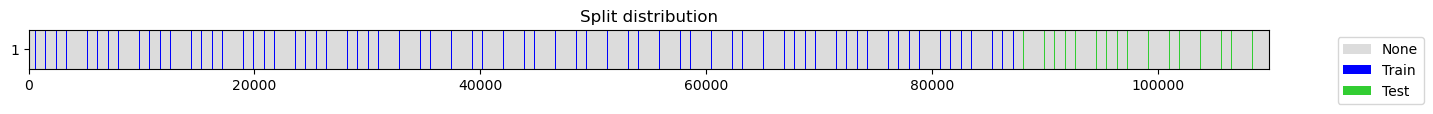

In [30]:
#| export
if config.analysis_mode == 'online': 
    splits = get_forecasting_splits(
        df = df_train, 
        fcst_history = config.w,
        fcst_horizon = 1,
        stride = config.stride, 
        test_size = 0.2,
        show_plot = True
    )
    
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X_strided)), valid_size=config.valid_size)

In [31]:
#| hide
if verbose > 0:
    display(splits)


((#5857) [11,26,41,56,71,86,101,116,131,146...],
 (#1464) [87866,87881,87896,87911,87926,87941,87956,87971,87986,88001...])

## MVP - Encoder training
Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [32]:
#| export
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [33]:
#| export
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

In [34]:
#| hide
if verbose > 0: print(X.shape)

(109812, 1, 30)


In [35]:
#| export
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)

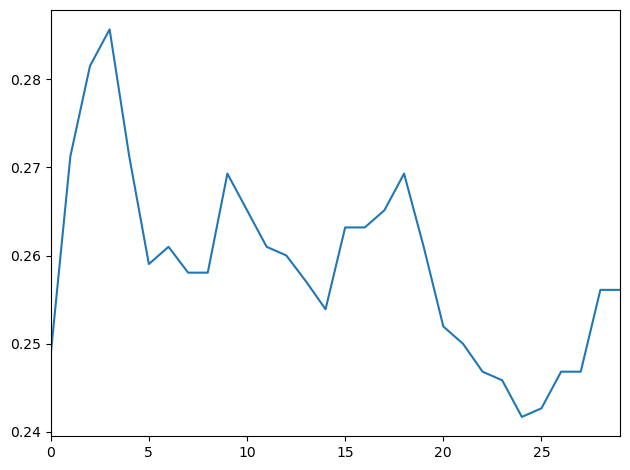

None

In [36]:
#| hide
if verbose > 0: display(dls.show_at(0))

#### Check dls

In [37]:
#| hide
if verbose > 0:
    print("X ~", X.shape) 
    print("dls batch size", dls.bs)


X ~ (109812, 1, 30)
dls batch size 512


#### Build MVP TS Learner

##### Auxiliar functions for ensuring absolute/percentage window size management and checking the result.

In [40]:
#| export
if (not window_size_percentage):
    from copy import deepcopy
    def ensure_expected_window_size(expected_window_size, verbose : int = 0):
        window_size = deepcopy(expected_window_size)
        if verbose > 0: print(window_size)
        window_size[0] = window_size[0] / window_size[1]
        if verbose > 0: 
            print(window_size)
            print(int(round(window_size[0]*window_size[1])))
        return window_size
    def check_expected_window_size(learn, expected_window_size, verbose : int = 0):
        # Find MVP calback
        obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
        if verbose > 0: print("obtained percentage", obtained_window_size)
        obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))
        if verbose > 0: print("obtained absolute", obtained_window_size)
        return obtained_window_size == expected_window_size

In [41]:
#| export
if not window_size_percentage:
    window_size = ensure_expected_window_size(config.mvp_ws)
else:
    window_size = config.mvp_ws
window_size

[0.5, 30]

##### Initialize learner

In [42]:
#| export
sgc = ShowGraphCallback2()
learn = ts_learner(dls, 
                   InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                       window_size=window_size, 
                       future_mask = config.mask_future, 
                       target_dir='./models', 
                       sync = config.mask_sync, 
                       stateful = config.mask_stateful,
                       fname=f'encoder_MVP',
                       verbose=False
                    ), y_range=[X.min(), X.max()])

#### Check learner

In [43]:
#| export
if not window_size_percentage:
    check_expected_window_size(learn, config.mvp_ws, verbose = verbose)
    if verbose > 0:
        print("learn dls.bs",  learn.dls.bs)

obtained percentage [0.5, 30]
obtained absolute [15, 30]
learn dls.bs 512


#### Example mask

##### Create mask

In [44]:
#| export
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

##### Show mask

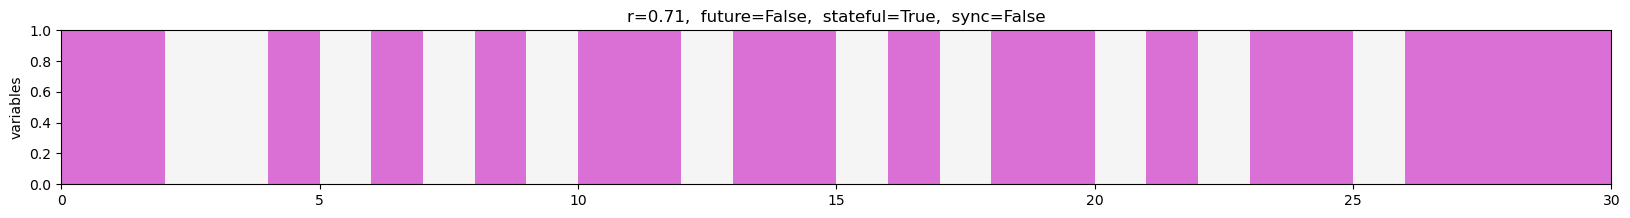

In [45]:
#| hide 
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 #### Check window size configuration

##### Check config attributes

In [46]:
#| export
expected_window_size = config.mvp_ws
np.random.randint(*config.mvp_ws)

23

In [47]:
#| hide
if verbose > 0:
    print("w", config.w, "mvp_ws", config.mvp_ws)
    print("expected ", expected_window_size)
    print(*config.mvp_ws)

w 30 mvp_ws [15, 30]
expected  [15, 30]
15 30


In [48]:
#| export
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)

In [49]:
#| hide
if verbose > 0: print("obtained ", obtained_window_size)

obtained  [0.5, 30]


In [50]:
#| export
obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))

In [51]:
#| hide
if verbose > 0: print("obtained ", obtained_window_size)

obtained  [15, 30]


In [52]:
#| export
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


##### Check w1 < w2 for MVP random window size selection

In [53]:
#| export
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    if verbose > 0: print(obtained_window_size)
    ws = np.random.randint(*obtained_window_size)
    if verbose > 0: print(ws)

[15, 30]
26


### Train the model

In [54]:
#| export
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
if verbose > 0: print("obtained ", obtained_window_size)

obtained  [0.5, 30]


In [55]:
#| hide
if check_memory_usage: gpu_memory_status(gpu_device)

GPU | Used mem: 21
GPU | Used mem: 24
GPU | Memory Usage: [█████████████████---] 88%


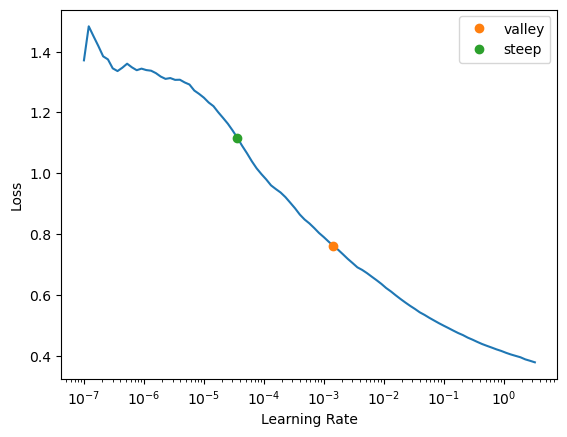

In [56]:
#| export
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

In [57]:
#| export
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)

In [58]:
#| hide
if verbose > 0: print("obtained ", obtained_window_size)

obtained  [15, 30]


In [59]:
#| export
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, verbose=1):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

obtained percentage [15, 30]
obtained absolute [450, 30]
[15, 30]
[0.5, 30]
15


In [60]:
#| export
if check_memory_usage: gpu_memory_status(gpu_device)

GPU | Used mem: 20
GPU | Used mem: 24
GPU | Memory Usage: [████████████████----] 83%


epoch     train_loss  valid_loss  time    
0         0.655074    1.222223    00:00            


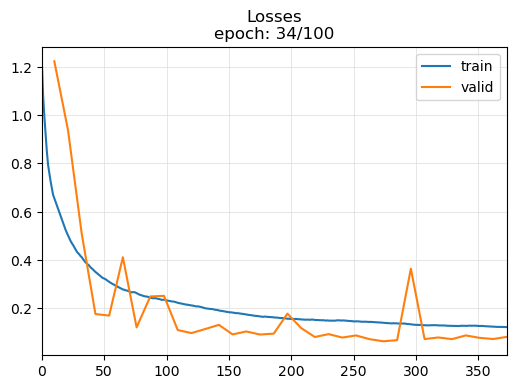

1         0.501382    0.936507    00:00            
2         0.410949    0.507683    00:00            
3         0.349787    0.175733    00:00            
4         0.309302    0.169249    00:00            
5         0.277467    0.411049    00:00            
6         0.262156    0.120472    00:00            
7         0.243457    0.248594    00:00            
8         0.235426    0.250956    00:00            
9         0.222258    0.109476    00:00             
10        0.211221    0.096852    00:00             
11        0.199584    0.113506    00:00             
12        0.190476    0.130976    00:00             
13        0.181520    0.091315    00:00             
14        0.174080    0.103618    00:00             
15        0.165868    0.090880    00:00             
16        0.161582    0.094476    00:00             
17        0.156120    0.177429    00:00             
18        0.153649    0.117609    00:00             
19        0.151575    0.080613    00:00             
2

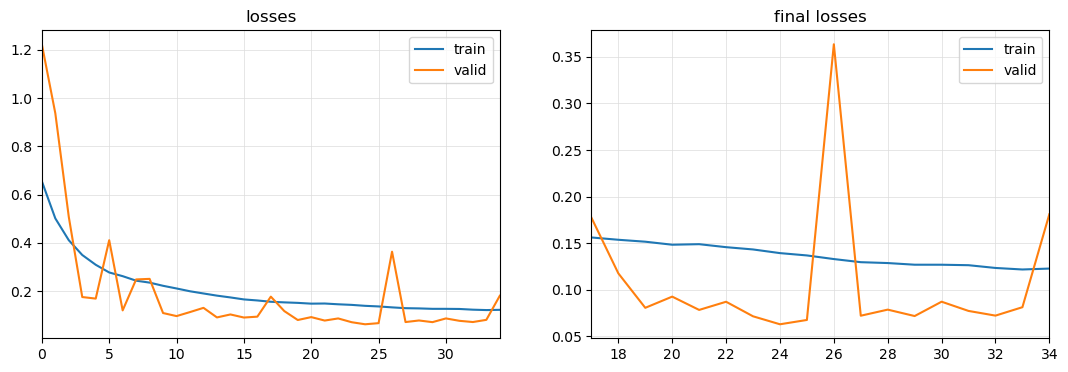

In [61]:
#| export
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

In [62]:
#| hide
if check_memory_usage: gpu_memory_status(gpu_device)

GPU | Used mem: 19
GPU | Used mem: 24
GPU | Memory Usage: [███████████████-----] 79%


#### Validate the model

In [63]:
#| export
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, verbose=1):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

obtained percentage [15, 30]
obtained absolute [450, 30]
[15, 30]
[0.5, 30]
15


In [64]:
#| export
learn.validate()

not enough values to plot a chart   


(#1) [2.001371145248413]

## Visualize predictions

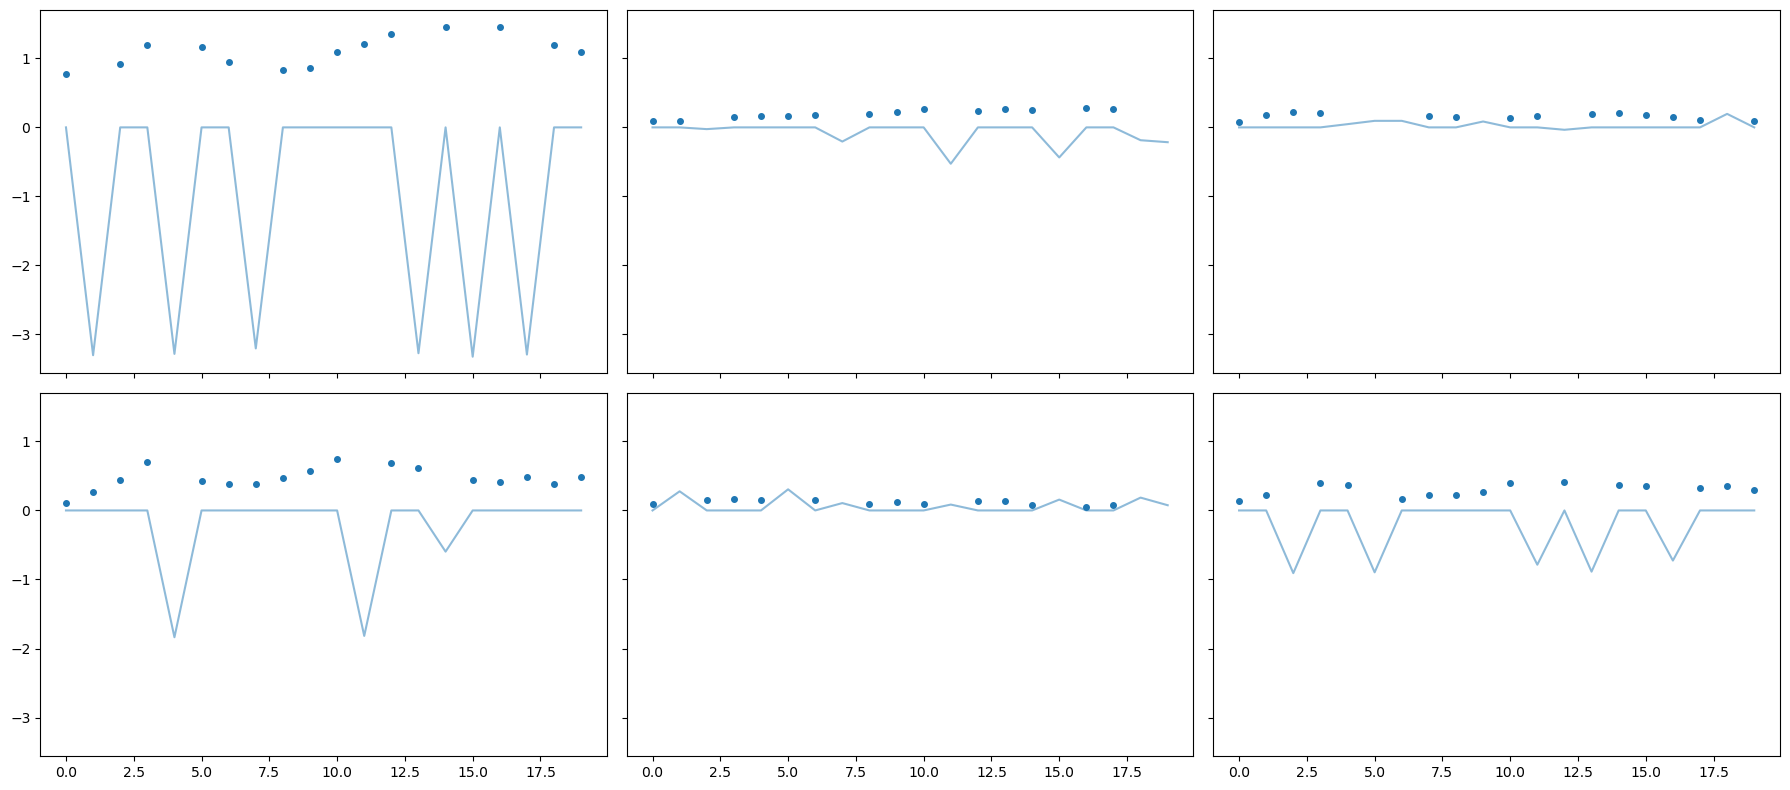

In [65]:
#| hide
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [66]:
#| export
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

In [67]:
#| export
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp-SWV', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [68]:
#| export
run.finish()

epoch,35
eps_0,1e-05
eps_1,1e-05
lr_0,0.00138
lr_1,0.00138
mom_0,0.85425
mom_1,0.85425
raw_loss,0.1204
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.12274


In [ ]:
#| export
print("Execution ended")
beep(1)
if reset_kernel:
    import os
    os._exit(00)

Execution ended
